In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ply
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

# Estimación de precio de casas en el condado de King

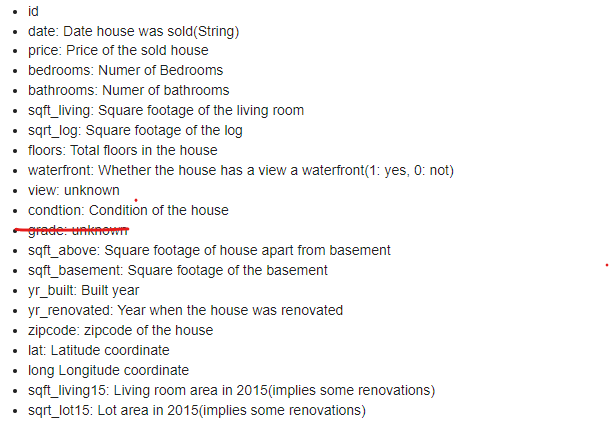

## Condition 
https://selling-guide.fanniemae.com/Underwriting-Property-Projects/Appraisal-Requirements/Appraisal-Report-Assessment/Property-Condition-Construction-Quality/1104684711/What-are-the-property-condition-ratings-used-by-the-appraiser.htm

Mejor casa 5 peor 0

## Grade

Leer https://www.yadkincountync.gov/DocumentCenter/View/776/Section-5?bidId=. 

Mejor casa 13 peor 0


## View

Mejor casa max y peor casa min




In [2]:
import platform
os = platform.system()
print("Current OS: ", os)

Current OS:  Windows


In [3]:
if os == "Darwin":
    print("MAC")
    archivo = "/Users/pacaicedo/DatasetsVault/HouseSalesKingCounty/kc_house_data.csv"
else:
    print("WIN")
    archivo = "D:/DatasetsVault/HouseSalesKingCounty/kc_house_data.csv"

datos = pd.read_csv(archivo)

WIN


## Revisión de estructura y de datos nulos.

No hay datos nulos, y hay que tener cuidado con la representación de las variable yr_built y yr_renovated para evitar ambiguedades. Estas variables no son numéricas sino categóricas ordinales. La variable ZIPCODE es una variable categórica. Para reflejar esa naturaleza se propone un **preprocesamiento**

In [4]:
datos.isna().sum()
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Eliminación de columnas

Le eliminan la column id por no presentar información relevante para el modelo. Las columnas "date", "lat", "long" se eliminan dado que no se pretende hacer un análisis de tipo serie temporal (date) ni un análisis espacial (Lat y long)

In [5]:
datos.drop(columns=["id", "date", "lat", "long"], inplace=True)

## Búsqueda de datos anómalos

- Las variable binaria: waterfront deben ser analizadas para saber si solo tienen dos valores unicos. 
- Variables ordinales: Condition, view y grade. Hay que estimar cuál es el orden de los valores. Dado que no existe la ayuda de un perito para valorar las variables se hace al ojo con gráficos de caja y bigotes

In [6]:
print(datos["waterfront"].unique())

[0 1]


<Axes: xlabel='grade', ylabel='price'>

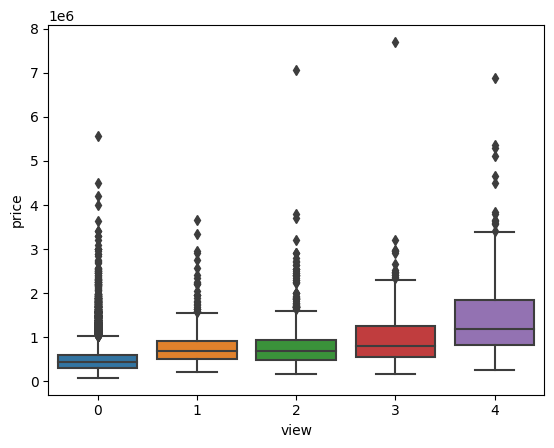

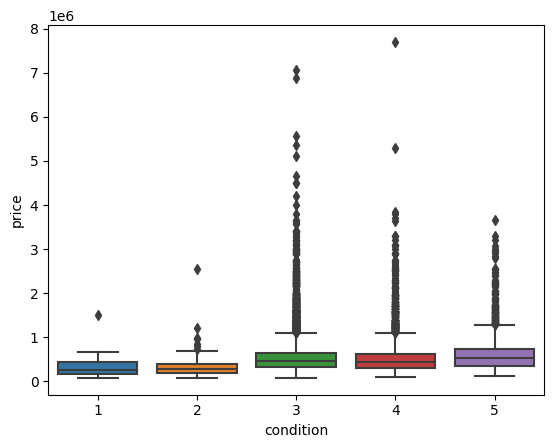

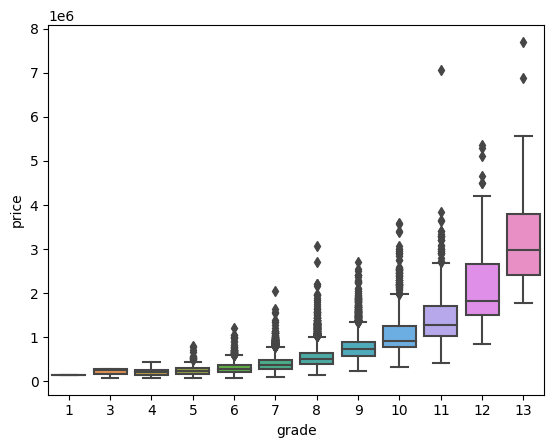

In [7]:
figura01 = plt.figure()
sns.boxplot(data=datos, x="view", y="price")
figura02 = plt.figure()
sns.boxplot(data=datos, x="condition", y="price")
figura03 = plt.figure()
sns.boxplot(data=datos, x="grade", y="price")

## Buscando relaciones

In [8]:
datos.drop(datos[datos.bedrooms==33].index, inplace=True) #Dato demasiado alejado de la dinámica de la relación
datos.drop(datos[datos.bathrooms>=7.5].index, inplace=True)
datos.drop(datos[(datos.bathrooms==4.5) & (datos.price==7.0625e6)].index, inplace=True)
datos.drop(datos[datos.sqft_living>=9200].index, inplace=True)

In [9]:
datos[(datos.bathrooms==4.5) & (datos.price==7.0625e6)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15


In [10]:
import plotly.express as px

figura = px.scatter_matrix(data_frame=datos, 
                           dimensions=["price", "bedrooms", "bathrooms", "sqft_living" ])
figura.show()

In [11]:
datos["log_sqft_living"] = datos.sqft_living.apply(np.log10)
datos["chg_sqft_living"] = np.abs(datos.sqft_living15-datos.sqft_living)

In [12]:
figura = px.scatter_matrix(data_frame=datos, 
                           dimensions=["price", "log_sqft_living", "chg_sqft_living", "sqft_living" ])
figura.show()

<Axes: >

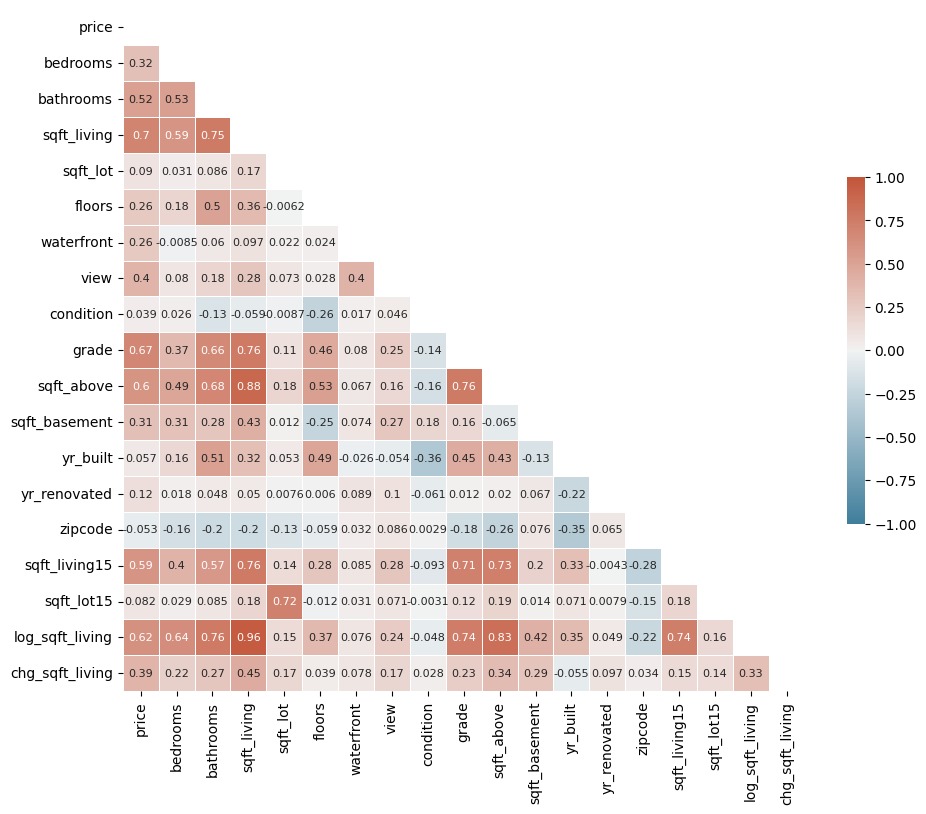

In [13]:
matCorrelation = datos.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matCorrelation, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(matCorrelation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, 
            annot_kws={"size":8})

## Seleccionar variables de entrada

In [14]:
input_numerical_variables = ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", 
                             "sqft_living15", "sqft_lot15", "log_sqft_living", "chg_sqft_living"]

input_num_data = datos[input_numerical_variables]
input_cat_data = datos.drop(columns=input_numerical_variables).drop(columns="price")

### Preprocesamiento de las entradas categóricas

In [15]:
dummy_encoder = OneHotEncoder().fit(input_cat_data)
enc_cat_data = dummy_encoder.transform(input_cat_data).toarray()

### Preprocesamiento de las entradas numéricas

In [16]:
escalador = StandardScaler().fit(input_num_data)
scaled_num_data = escalador.transform(input_num_data)

### Creación del conjunto de datos de entrada

In [17]:
input_ds = np.concatenate((enc_cat_data, scaled_num_data), axis=1)

### Creación de conjuntos de entranamiento y prueba

In [18]:
x_train, x_test, y_train, y_test = train_test_split(input_ds, datos.price.values, test_size=0.3, random_state=54)

## Creación del modelo de red neuronal

In [19]:
class RedNeuronal(nn.Module):

    def __init__(self, nentradas) -> None:
        super(RedNeuronal, self).__init__()
        self.linear1 = nn.Linear(nentradas, 100)
        self.linear2 = nn.Linear(100, 1400)
        self.linear3 = nn.Linear(1400, 200)
        self.linear4 = nn.Linear(200,1)

    def forward(self, inputs):
        pred_1 = torch.relu(input=self.linear1(inputs))
        pred_2 = torch.relu(input=self.linear2(pred_1))
        pred_3 = torch.relu(input=self.linear3(pred_2))
        pred_4 = torch.relu(input=self.linear4(pred_3))
        return pred_4

## Variables de preparación para entrenamiento  

### Definición de máquina de procesamiento

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Conversión de datos a tensores pytorch

In [21]:
txtrain = torch.from_numpy(x_train).float().to(device)
tytrain = torch.from_numpy(y_train).float().to(device)
txtest = torch.from_numpy(x_test).float().to(device)
tytest = torch.from_numpy(y_test).float().to(device)

### Definición de hiperparametros para el entrenamiento del modelo

In [22]:
lr = 0.001
epochs = 2000
estatus_print = 100
n_entradas = x_train.shape[1]
historico = pd.DataFrame()

## Entrenamiento

### Inicialización de red neuronal

In [23]:
modelo = RedNeuronal(nentradas=n_entradas)
modelo.to(device=device)
loss_fn = nn.L1Loss()
optimizador = torch.optim.AdamW(params= modelo.parameters(), lr=lr )
print("Arquitectura del modelo: {}".format(modelo))

Arquitectura del modelo: RedNeuronal(
  (linear1): Linear(in_features=333, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1400, bias=True)
  (linear3): Linear(in_features=1400, out_features=200, bias=True)
  (linear4): Linear(in_features=200, out_features=1, bias=True)
)


### Entrenamiento del modelo

In [24]:
for epoch in range(0, epochs):
    y_pred = modelo(txtrain)
    tytrain = torch.reshape(tytrain, y_pred.shape)
    perdida = loss_fn(input=y_pred, target=tytrain)
    perdida.backward()
    optimizador.step()
    optimizador.zero_grad()
    if epoch % estatus_print == 0:
        print(f"\nEpoch {epoch} \t Loss: {round(perdida.item(), 4)}")

    with torch.no_grad():
        y_pred = modelo(txtest)

        r2score = 100 * r2_score(tytest.cpu().numpy(), y_pred.cpu().numpy())

        if epoch % estatus_print == 0:
            print("R2 score: {}".format(r2score))


    df_tmp = pd.DataFrame(data={
        'Epoch': epoch,
        'Loss': round(perdida.item(), 4),
        'Accuracy': round(r2score, 4)
    }, index=[0])
    historico = pd.concat(objs=[historico, df_tmp], ignore_index=True, sort=False)
print("R2 Score final: {}".format(round(r2score, 4)))


Epoch 0 	 Loss: 536634.1875
R2 score: -218.69052347899122

Epoch 100 	 Loss: 427313.5938
R2 score: -142.17188313253803

Epoch 200 	 Loss: 141282.9844
R2 score: 48.263244223910526

Epoch 300 	 Loss: 108957.3828
R2 score: 63.578877382200304

Epoch 400 	 Loss: 92854.5
R2 score: 70.46453537506754

Epoch 500 	 Loss: 84930.5234
R2 score: 74.86175748724364

Epoch 600 	 Loss: 80068.0469
R2 score: 78.241294191241

Epoch 700 	 Loss: 76926.3203
R2 score: 80.65634340937542

Epoch 800 	 Loss: 74447.2734
R2 score: 82.3184988002875

Epoch 900 	 Loss: 72259.8828
R2 score: 83.66143265363158

Epoch 1000 	 Loss: 70605.4688
R2 score: 84.44342619717709

Epoch 1100 	 Loss: 69190.4375
R2 score: 85.08345902896156

Epoch 1200 	 Loss: 67910.6797
R2 score: 85.52597509947984

Epoch 1300 	 Loss: 66743.6719
R2 score: 85.8862228073741

Epoch 1400 	 Loss: 65652.8281
R2 score: 86.12836556255073

Epoch 1500 	 Loss: 64613.8281
R2 score: 86.33372549037918

Epoch 1600 	 Loss: 63536.3047
R2 score: 86.56039551034893

Epoch